In [1]:
from fastai.vision.all import *
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# check if cuda is available
print(torch.cuda.is_available())

True


## Filter Dataset for only images where the mask contains a car

In [3]:
# Function to count .npy files with sum > 0
def count_files_with_sum_gt_zero(folder):
    count = 0
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith('.npy'):
                file_path = os.path.join(root, file)
                array = np.load(file_path)
                if np.sum(array) > 0:
                    count += 1
    return count

In [4]:
folder_path = '/kaggle/input/car-street-data/train_test_split_car'
# Count for the 'train' folder
train_count = count_files_with_sum_gt_zero(os.path.join(folder_path, 'train'))
print(f'Count of .npy files with sum > 0 in "train" folder: {train_count}')

# Count for the 'test' folder
test_count = count_files_with_sum_gt_zero(os.path.join(folder_path, 'test'))
print(f'Count of .npy files with sum > 0 in "test" folder: {test_count}')

# Count for the 'validation' folder
validation_count = count_files_with_sum_gt_zero(os.path.join(folder_path, 'validation'))
print(f'Count of .npy files with sum > 0 in "validation" folder: {validation_count}')

Count of .npy files with sum > 0 in "train" folder: 1045
Count of .npy files with sum > 0 in "test" folder: 295
Count of .npy files with sum > 0 in "validation" folder: 151


## define the trainer

In [5]:
def find_files_by_pattern(folder, pattern):
    matching_files = []
    
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(pattern):
                matching_files.append(root + "/" + file)

    return matching_files

def get_images_filtered(name):
    image_files = []
    for file in find_files_by_pattern(folder_path, "img.jpg"):
        # get npy file
        npy_path = os.path.join(os.path.dirname(file), "label.npy")
        array = np.load(npy_path)
        if np.sum(array) > 0:
            image_files.append(Path(file))
    return image_files

def get_images_all(name):
    image_files = []
    for file in find_files_by_pattern(folder_path, "img.jpg"):
        image_files.append(Path(file))
    return image_files

In [6]:
# define a function to get the numpy mask for the given path
def get_mask(path):
    #remove the file name and extension from the path
    path = path.parent 
    # add the name mask.npy to the path
    path = path.joinpath("label.npy")
    return np.load(path)

In [7]:
aerial_Block_all = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ["nothing","car"])),
                            splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                            get_items=get_images_all,
                            get_y=get_mask,
                            batch_tfms=aug_transforms(size=500, max_lighting=0.3))

In [8]:
dataloader_all = aerial_Block_all.dataloaders("./",bs=8)

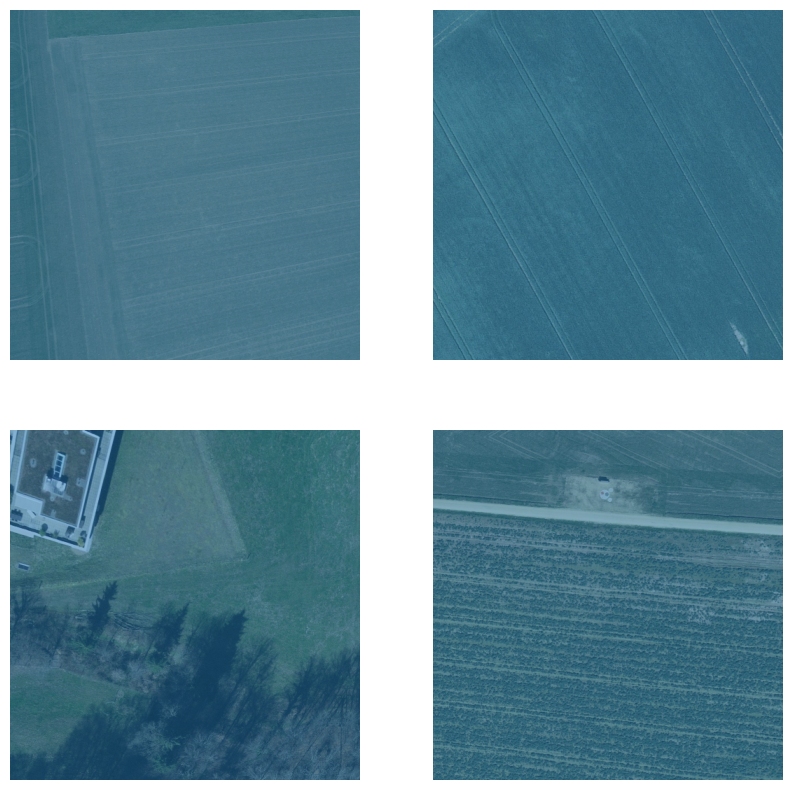

In [9]:
dataloader_all.show_batch(max_n=4,figsize=(10,10))

## Define metrics

In [10]:
# define functions to calculate desired metrics
def convert_preds_and_target(pred, target):
    # convert predictions to numpy array with max probability index
    pred = pred.argmax(dim=1).cpu().numpy()
    # convert target to numpy array
    target = target.cpu().numpy()

    return pred, target

def calculate_intersect_union(pred, target):
    # calculate intersection and union
    intersection = np.logical_and(target, pred)
    union = np.logical_or(target, pred)

    return intersection, union

def calculate_iou(intersection, union):
    # calculate intersection over union
    return np.sum(intersection) / np.sum(union) if np.sum(union) != 0 else 1

def calculate_accuracy(pred, target):
    # calculate accuracy
    return np.sum(pred == target) / np.prod(target.shape)

def calculate_dice(intersection, union):
    # calculate dice coefficient
    return 2 * np.sum(intersection) / (np.sum(union) + np.sum(intersection)) if np.sum(union) != 0 else 1

def iou(pred, target):
    # convert predictions and target to numpy arrays
    pred, target = convert_preds_and_target(pred, target)
    # calculate intersection and union
    intersection, union = calculate_intersect_union(pred, target)
    # calculate intersection over union
    return calculate_iou(intersection, union)

def dice(pred, target):
    # convert predictions and target to numpy arrays
    pred, target = convert_preds_and_target(pred, target)
    # calculate intersection and union
    intersection, union = calculate_intersect_union(pred, target)
    # calculate dice coefficient
    return calculate_dice(intersection, union)

def accuracy(pred, target):
    # convert predictions and target to numpy arrays
    pred, target = convert_preds_and_target(pred, target)
    # calculate accuracy
    return calculate_accuracy(pred, target)

## Train the Model

In [11]:
torch.cuda.empty_cache()

In [12]:
learner_all = unet_learner(dataloader_all,resnet34,metrics=[dice, iou, accuracy])

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 72.0MB/s]


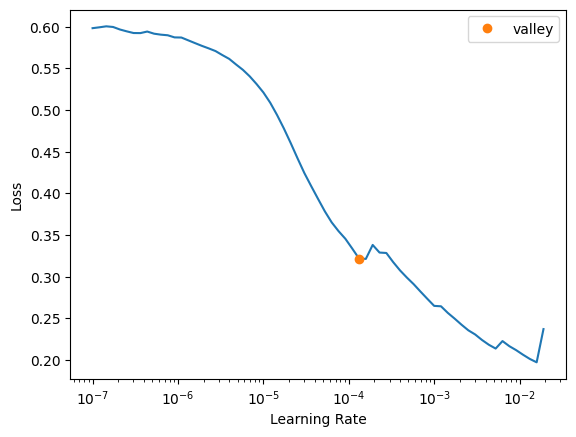

In [13]:
lr = learner_all.lr_find()

In [14]:
learner_all.fit_one_cycle(20, lr_max=lr.valley, cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.01, patience=5, comp=np.greater),
                                        SaveModelCallback(monitor='dice', min_delta=0.01, comp=np.greater, fname='best_frozen_model')])

epoch,train_loss,valid_loss,dice,iou,accuracy,time
0,0.026785,0.014426,0.094737,0.094737,0.998409,02:36
1,0.008645,0.004833,0.113057,0.079600,0.998443,02:36
2,0.005505,0.003510,0.472745,0.338649,0.998682,02:37
3,0.004718,0.003474,0.479140,0.346373,0.998692,02:37
4,0.004748,0.003244,0.506726,0.373167,0.998811,02:37
5,0.003952,0.003981,0.579166,0.446105,0.998482,02:36
6,0.004297,0.002939,0.603306,0.472827,0.998839,02:36
7,0.003532,0.002960,0.600752,0.470071,0.998945,02:36
8,0.003425,0.002628,0.637368,0.509329,0.998986,02:36
9,0.002782,0.002382,0.655568,0.523515,0.999089,02:36


Better model found at epoch 0 with dice value: 0.09473684210526316.
Better model found at epoch 1 with dice value: 0.11305720904324161.
Better model found at epoch 2 with dice value: 0.4727453814745892.
Better model found at epoch 4 with dice value: 0.5067261690732675.
Better model found at epoch 5 with dice value: 0.5791660833660028.
Better model found at epoch 6 with dice value: 0.603306278198863.
Better model found at epoch 8 with dice value: 0.6373676813882645.
Better model found at epoch 9 with dice value: 0.6555677789899902.
Better model found at epoch 11 with dice value: 0.6780230482782477.
Better model found at epoch 14 with dice value: 0.6950030307336326.
No improvement since epoch 14: early stopping


## unfreeze and retrain

In [15]:
aerial_Block_filtered = DataBlock(blocks = (ImageBlock, MaskBlock(codes = ["nothing","car"])),
                            splitter=GrandparentSplitter(train_name='train', valid_name='test'),
                            get_items=get_images_filtered,
                            get_y=get_mask,
                            batch_tfms=aug_transforms(size=500, max_lighting=0.3))
dataloader_filtered = aerial_Block_filtered.dataloaders("./",bs=8)

learner_filtered = unet_learner(dataloader_filtered,resnet34,metrics=[dice, iou, accuracy])
learner_filtered = learner_filtered.load('best_frozen_model')
learner_filtered.unfreeze()

/opt/conda/lib/python3.10/site-packages/fastai/learner.py:59: UserWarning: Saved file doesn't contain an optimizer state.
  elif with_opt: warn("Saved file doesn't contain an optimizer state.")


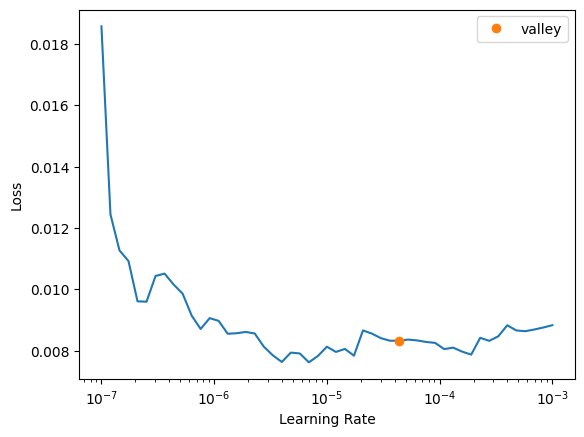

In [16]:
lr = learner_filtered.lr_find()

In [17]:
learner_filtered.fit_one_cycle(
    10, lr_max=slice(lr.valley/10,lr.valley*10),
    cbs=[EarlyStoppingCallback(monitor='dice', min_delta=0.005, patience=5, comp=np.greater),
         SaveModelCallback(monitor='dice', comp=np.greater, fname='best_model')]
         )

epoch,train_loss,valid_loss,dice,iou,accuracy,time
0,0.007887,0.007924,0.739642,0.594915,0.996978,00:45
1,0.010563,0.009705,0.557776,0.390577,0.995851,00:45
2,0.009883,0.007568,0.706498,0.553921,0.997128,00:45
3,0.008753,0.008294,0.696892,0.543264,0.996663,00:45
4,0.008019,0.006950,0.751581,0.608783,0.997448,00:45
5,0.007712,0.007369,0.747087,0.604949,0.997044,00:45
6,0.006717,0.007272,0.750020,0.609323,0.997174,00:45
7,0.006155,0.006679,0.768488,0.632008,0.997403,00:45
8,0.005866,0.006931,0.762299,0.624726,0.997275,00:45
9,0.005832,0.006620,0.766983,0.629593,0.997472,00:45


Better model found at epoch 0 with dice value: 0.739641790979563.
Better model found at epoch 4 with dice value: 0.7515812092716035.
Better model found at epoch 7 with dice value: 0.768488192065361.


## Inference Testing

In [18]:
learner_filtered.load('best_model')

In [19]:
image_path = "/kaggle/input/car-segmentation/train_test_split/test/25961_12102/img.jpg" 

prediction_car = learner_filtered.predict(image_path)[0].numpy()
prediction_car = np.array(Image.fromarray(prediction_car.astype(np.uint8)).resize((1000, 1000))).astype('float32')

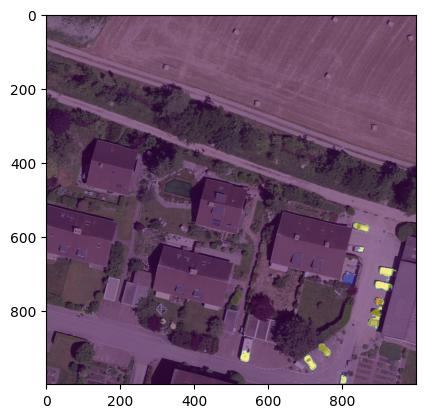

In [20]:
image = np.array(Image.open(image_path))

plt.imshow(image)
plt.imshow(prediction_car,alpha=0.5)
plt.plot();